## Overview

Here is competition page

https://www.kaggle.com/c/kdd-cup-2014-predicting-excitement-at-donors-choose/data

Now combining these few datasets we have created the below 
<br>train dataset and resources dataset that we will preprocess for our project.

### Imports

In [194]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from prettytable import PrettyTable

In [195]:
from google.colab import drive
drive.mount('/content/gdrive/')
path = 'My Drive/'

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [196]:
path = '/content/gdrive/My Drive/'
df = pd.read_csv(path+'preprocessed_data.csv')

In [197]:
# df.head()

In [198]:
df.project_is_approved.value_counts()

1    92706
0    16542
Name: project_is_approved, dtype: int64

In [199]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109248 entries, 0 to 109247
Data columns (total 9 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   school_state                                  109248 non-null  object 
 1   teacher_prefix                                109248 non-null  object 
 2   project_grade_category                        109248 non-null  object 
 3   teacher_number_of_previously_posted_projects  109248 non-null  int64  
 4   project_is_approved                           109248 non-null  int64  
 5   clean_categories                              109248 non-null  object 
 6   clean_subcategories                           109248 non-null  object 
 7   essay                                         109248 non-null  object 
 8   price                                         109248 non-null  float64
dtypes: float64(1), int64(2), object(6)
memory usage: 

In [200]:
def label_encode(col_name, df):
    
    le = preprocessing.LabelEncoder()
    df[col_name] = le.fit_transform(df[col_name])
    
    return df
    
df = label_encode('school_state', df)
df = label_encode('teacher_prefix' , df)
df = label_encode('project_grade_category', df)
df = label_encode('clean_categories'  , df)
df = label_encode('clean_subcategories', df)

In [201]:
vectorizer = TfidfVectorizer()
vectorizer.fit(df['essay'].values)

TfidfVectorizer()

In [202]:
vec_feat = vectorizer.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [203]:
pd.read_csv(path+'preprocessed_data.csv').columns

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price'],
      dtype='object')

In [204]:
features = ['school_state', 'teacher_prefix', 'project_grade_category',
       'clean_categories', 'clean_subcategories', 'price']
features.extend(list(vec_feat))

In [205]:
len(features)

56351

In [206]:
y = df['project_is_approved'].values
X = df.drop(['project_is_approved', 'teacher_number_of_previously_posted_projects'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

### Categorical Col EDA

In [207]:
def check_cat(name):
  plt.figure(figsize=(15,5))
  X_train[name].hist(bins=30)
  plt.xticks(rotation=45)
  plt.show()

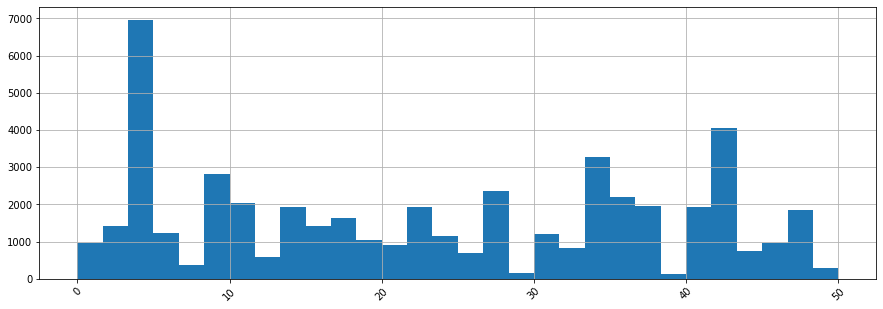

In [208]:
check_cat('school_state')

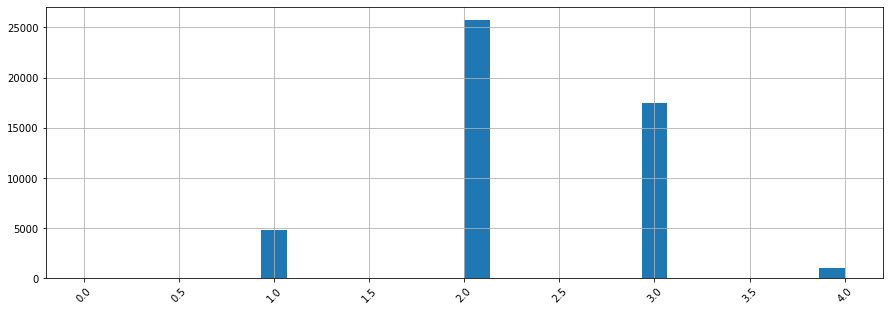

In [209]:
check_cat('teacher_prefix')

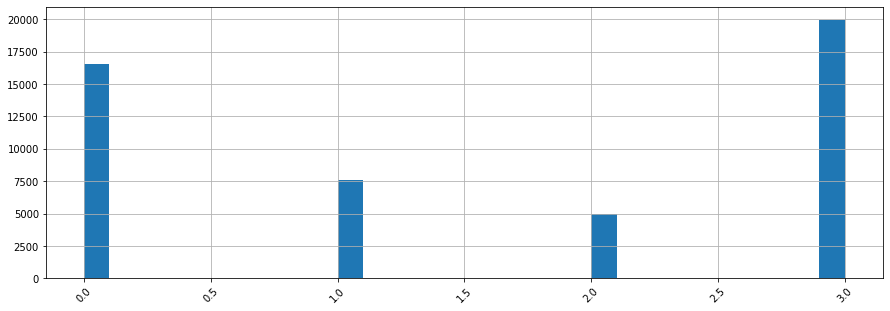

In [210]:
check_cat('project_grade_category')

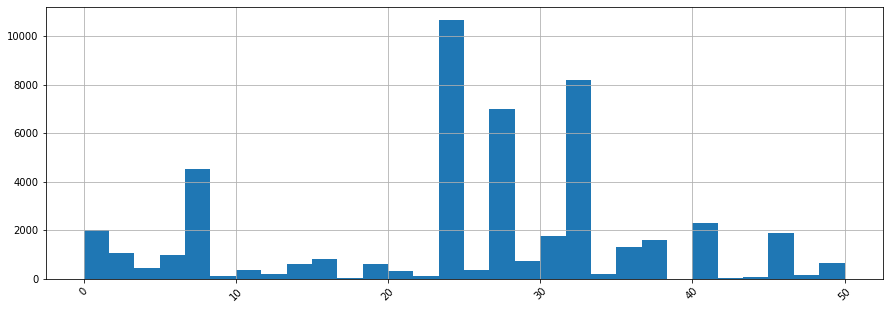

In [211]:
check_cat('clean_categories')

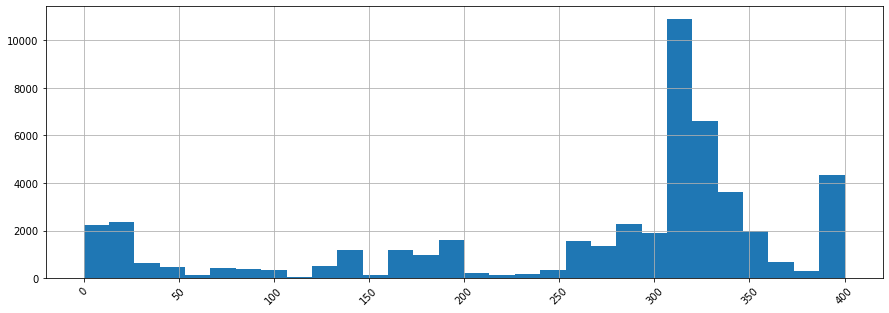

In [212]:
check_cat('clean_subcategories')

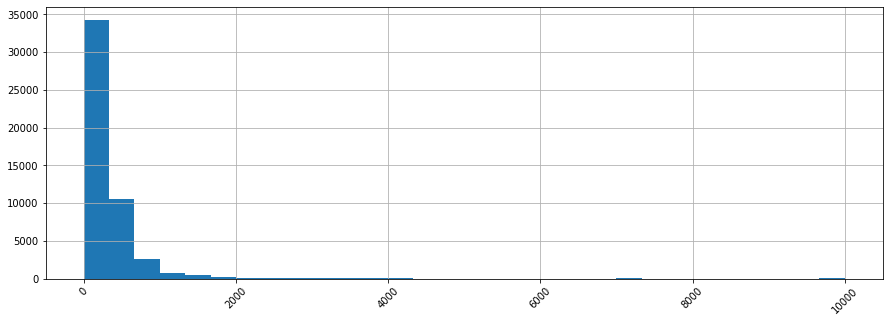

In [213]:
check_cat('price')

### Class Imbalance

There is class imbalance in the dataset so we need to take care of that.

In [214]:
tdf = X_train.copy()
tdf['project_is_approved'] = y_train

In [215]:
tdf.project_is_approved.value_counts()

1    41615
0     7426
Name: project_is_approved, dtype: int64

In [216]:
# class count
class_count_0, class_count_1 = tdf['project_is_approved'].value_counts()

# Separate class
class_0 = tdf[tdf['project_is_approved'] == 0]
class_1 = tdf[tdf['project_is_approved'] == 1]# print the shape of the class
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)

class 0: (7426, 8)
class 1: (41615, 8)


In [217]:
# Undersampling

class_1_under = class_1.sample(25000)

In [218]:
test_under = pd.concat([class_1_under, class_0], axis=0)

In [219]:
test_under.project_is_approved.value_counts()

1    25000
0     7426
Name: project_is_approved, dtype: int64

In [220]:
# Oversampling

class_0_over = class_0.sample(25000, replace=True)

In [221]:
test_over = pd.concat([class_0_over, class_1], axis=0)

In [222]:
test_over.project_is_approved.value_counts()

1    41615
0    25000
Name: project_is_approved, dtype: int64

In [223]:
tdf = pd.concat([test_under[test_under.project_is_approved == 1], 
           test_over[test_over.project_is_approved == 0]], axis=0)

In [224]:
tdf.project_is_approved.value_counts()

1    25000
0    25000
Name: project_is_approved, dtype: int64

In [225]:
y_train = tdf['project_is_approved']
X_train = tdf.drop(['project_is_approved', ], axis=1)

### TFIDF for Essay column

In [226]:
def stack_vect(X, vectorizer):
    
    X_vect = vectorizer.transform(X['essay'].values)
    X.drop(['essay'], axis=1, inplace=True)
    X = hstack((X, X_vect)).tocsr()
    
    return X

X_train = stack_vect(X_train, vectorizer)
X_cv = stack_vect(X_cv, vectorizer)
X_test = stack_vect(X_test, vectorizer)

In [227]:
def scores(clf, X_train, y_train, X_cv, y_cv, ret):
    
    y_pred = clf.predict(X_train)
    tacc = accuracy_score(y_train, y_pred)
  
    y_pred = clf.predict(X_cv)
    vacc = accuracy_score(y_cv, y_pred)

    if ret:
      return tacc, vacc
    else:
      print('Train Accuracy: ', tacc)
      print('Val Accuracy: ', vacc)

In [228]:
def get_feat_imp(features, clf):
  imp_df = pd.DataFrame({'features':features, 'imp':clf.feature_importances_}).sort_values(by=['imp'], ascending=False)
  imp_df = imp_df[:50]
  plt.figure(figsize=(5,25))
  sns.barplot(x=imp_df.imp, y=imp_df.features)
  plt.xticks(rotation=90)
  plt.show()

In [229]:
def plot_auc(clf, X_cv, y_cv):
  y_train_pred =   clf.predict(X_train)
  y_test_pred = clf.predict(X_cv)

  train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
  test_fpr, test_tpr, te_thresholds = roc_curve(y_cv, y_test_pred)

  plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
  plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
  plt.legend()
  plt.ylabel("AUC")
  plt.title("ERROR PLOTS")
  plt.grid()
  plt.show()

In [230]:
def get_conf(clf, X_cv, y_cv):
  
  print('Conf Mat on Train Data:')
  cm = confusion_matrix(y_train, clf.predict(X_train), labels=clf.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=clf.classes_)
  disp.plot()
  plt.show()

  print('Conf Mat on Val Data:')
  cm = confusion_matrix(y_cv, clf.predict(X_cv), labels=clf.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=clf.classes_)
  disp.plot()
  plt.show()

In [231]:
def disp_comprehensive_res(clf, X_cv, y_cv):
  scores(clf, X_train, y_train, X_cv, y_cv, False)
  get_feat_imp(features, clf)
  get_conf(clf, X_cv, y_cv)
  plot_auc(clf, X_cv, y_cv)

### Baseline DTClassifier

In [232]:
# from sklearn.tree import DecisionTreeClassifier


# clf = DecisionTreeClassifier(random_state=0)
# clf.fit(X_train, y_train)

In [233]:
# scores(clf, X_train, y_train, X_cv, y_cv, False)

In [234]:
# %%time
# clf = DecisionTreeClassifier()
# parameters = {  
#                 'max_depth': [2, 3, 5, 10, 20],
#                 'min_samples_leaf': [5, 10, 20, 50, 100],
#                 'criterion': ["gini", "entropy"]
#              }
# clf = GridSearchCV(clf, parameters, cv=5, scoring='roc_auc')
# clf.fit(X_train, y_train)

# scores(clf, X_train, y_train, X_cv, y_cv)

In [235]:
# clf.best_params_

In [236]:
# {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 5}

In [237]:
# conf mat, f1, acc, auc roc
# imp features
# word cloud

# try w2v tfidf
# try NB
# GBDT

# try one of the three deep learning models

In [238]:
# clf = DecisionTreeClassifier(criterion= 'gini', max_depth = 20, min_samples_leaf = 5)
# clf.fit(X_train, y_train)
# scores(clf, X_train, y_train, X_cv, y_cv, False)

In [239]:
# %%time
# tacc_l = []
# vacc_l = []

# max_depths = [20, 50, 100, 200, 500]
# for i in max_depths:
  
#   clf = DecisionTreeClassifier(criterion= 'gini', max_depth = i, min_samples_leaf = 5)
#   clf.fit(X_train, y_train)

#   tacc, vacc = scores(clf, X_train, y_train, X_cv, y_cv, True)
#   tacc_l.append(tacc)
#   vacc_l.append(vacc)

# plt.plot(max_depths, tacc_l, label='Train')
# plt.plot(max_depths, vacc_l, label='Validation')

# plt.legend()
# plt.show()

In [240]:
clf = DecisionTreeClassifier(criterion= 'gini', max_depth = 25, min_samples_leaf = 5)
clf.fit(X_train, y_train)
scores(clf, X_train, y_train, X_cv, y_cv, False)

Train Accuracy:  0.8555
Val Accuracy:  0.6228110122127923


In [241]:
# imp_df = pd.DataFrame({'features':features, 'imp':clf.feature_importances_}).sort_values(by=['imp'], ascending=False)
# imp_df = imp_df[:100]

In [242]:
# indexes = [features.index(i) for i in list(imp_df.features.values)]

In [243]:
# clf = DecisionTreeClassifier(max_depth = 15)
# clf.fit(X_train[:,indexes], y_train)
# scores(clf, X_train[:,indexes], y_train, X_cv[:,indexes], y_cv, False)

Train Accuracy:  0.8555
Val Accuracy:  0.6228110122127923


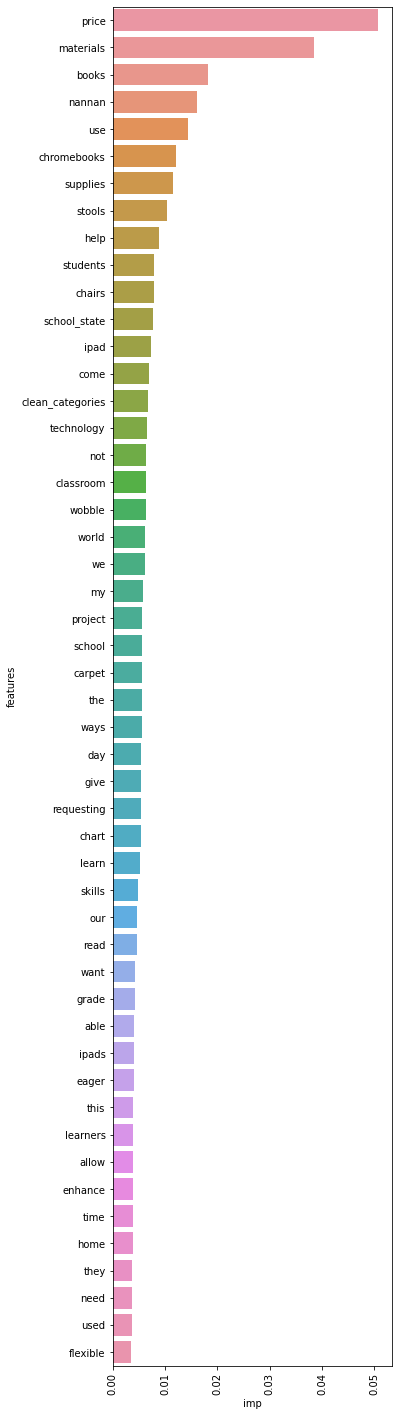

Conf Mat on Train Data:


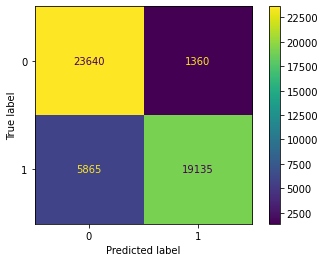

Conf Mat on Val Data:


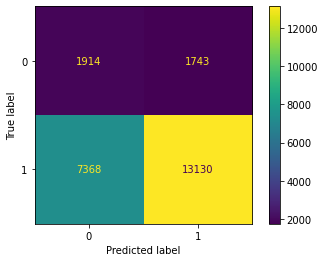

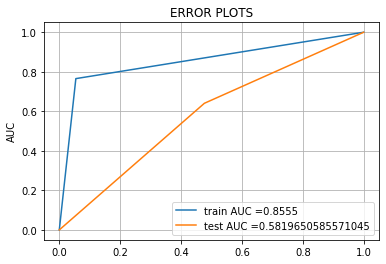

In [244]:
disp_comprehensive_res(clf, X_cv, y_cv)

### Randomforest Classifier

In [245]:
# %%time
# Baseline 


# rfr = RandomForestClassifier()
# rfr.fit(X_train, y_train)

In [246]:
# disp_comprehensive_res(rfr, X_cv, y_cv)

In [247]:
# {'bootstrap': [True, False],
#  'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#  'max_features': ['auto', 'sqrt'],
#  'min_samples_leaf': [1, 2, 4],
#  'min_samples_split': [2, 5, 10],
#  'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [248]:
# %%time
# clf = RandomForestClassifier()
# parameters = {
#               # 'bootstrap': [True, False],
#               'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#               # 'max_features': ['auto', 'sqrt'],
#               # 'min_samples_leaf': [1, 2, 4],
#               # 'min_samples_split': [2, 5, 10],
#               'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
#               }

# clf = GridSearchCV(clf, parameters, cv=5, scoring='roc_auc')
# clf.fit(X_train, y_train)

# scores(clf, X_train, y_train, X_cv, y_cv, False)

In [249]:
# clf.best_params_

In [250]:
# disp_comprehensive_res(clf, X_cv, y_cv)

In [251]:
# %%time

# tacc_l = []
# vacc_l = []

# max_depths = [20, 50, 100, 200, 500]
# for i in max_depths:
  
#   clf = RandomForestClassifier(max_depth = i, n_estimators=100)
#   clf.fit(X_train, y_train)

#   tacc, vacc = scores(clf, X_train, y_train, X_cv, y_cv, True)
#   tacc_l.append(tacc)
#   vacc_l.append(vacc)

# plt.plot(max_depths, tacc_l, label='Train')
# plt.plot(max_depths, vacc_l, label='Validation')

# plt.legend()
# plt.show()

In [252]:
# %%time

# tacc_l = []
# vacc_l = []

# max_depths = [20, 50, 100, 200, 500]
# for i in max_depths:
  
#   clf = RandomForestClassifier(max_depth = i, n_estimators=500)
#   clf.fit(X_train, y_train)

#   tacc, vacc = scores(clf, X_train, y_train, X_cv, y_cv, True)
#   tacc_l.append(tacc)
#   vacc_l.append(vacc)

# plt.plot(max_depths, tacc_l, label='Train')
# plt.plot(max_depths, vacc_l, label='Validation')

# plt.legend()
# plt.show()

In [253]:
# %%time

# tacc_l = []
# vacc_l = []

# max_depths = [5, 10, 20]
# for i in max_depths:
  
#   clf = RandomForestClassifier(max_depth = i, n_estimators=500)
#   clf.fit(X_train, y_train)

#   tacc, vacc = scores(clf, X_train, y_train, X_cv, y_cv, True)
#   tacc_l.append(tacc)
#   vacc_l.append(vacc)

# plt.plot(max_depths, tacc_l, label='Train')
# plt.plot(max_depths, vacc_l, label='Validation')

# plt.legend()
# plt.show()

In [254]:
# %%time

# tacc_l = []
# vacc_l = []

# max_depths = [5, 10, 20]
# for i in max_depths:
  
#   clf = RandomForestClassifier(max_depth = i, n_estimators=700)
#   clf.fit(X_train, y_train)

#   tacc, vacc = scores(clf, X_train, y_train, X_cv, y_cv, True)
#   tacc_l.append(tacc)
#   vacc_l.append(vacc)

# plt.plot(max_depths, tacc_l, label='Train')
# plt.plot(max_depths, vacc_l, label='Validation')

# plt.legend()
# plt.show()

In [255]:
# %%time

# tacc_l = []
# vacc_l = []

# max_depths = [5, 10, 20]
# for i in max_depths:
  
#   clf = RandomForestClassifier(max_depth = i, n_estimators=1000)
#   clf.fit(X_train, y_train)

#   tacc, vacc = scores(clf, X_train, y_train, X_cv, y_cv, True)
#   tacc_l.append(tacc)
#   vacc_l.append(vacc)

# plt.plot(max_depths, tacc_l, label='Train')
# plt.plot(max_depths, vacc_l, label='Validation')

# plt.legend()
# plt.show()

In [256]:
# %%time

# tacc_l = []
# vacc_l = []

# max_depths = [5, 7, 8, 9, 10, 12, 15]
# for i in max_depths:
  
#   clf = RandomForestClassifier(max_depth = i, n_estimators=100)
#   clf.fit(X_train, y_train)

#   tacc, vacc = scores(clf, X_train, y_train, X_cv, y_cv, True)
#   tacc_l.append(tacc)
#   vacc_l.append(vacc)

# plt.plot(max_depths, tacc_l, label='Train')
# plt.plot(max_depths, vacc_l, label='Validation')

# plt.legend()
# plt.show()

In [257]:
rfr = RandomForestClassifier(max_depth = 9, n_estimators=100)
rfr.fit(X_train, y_train)
scores(rfr, X_train, y_train, X_cv, y_cv, False)

Train Accuracy:  0.76438
Val Accuracy:  0.6969157524322086


Train Accuracy:  0.76438
Val Accuracy:  0.6969157524322086


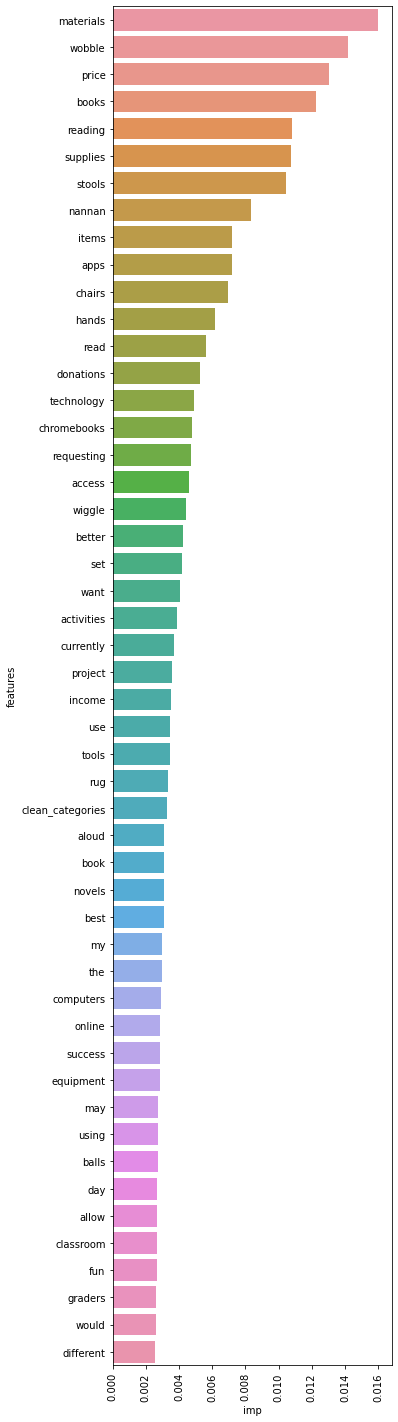

Conf Mat on Train Data:


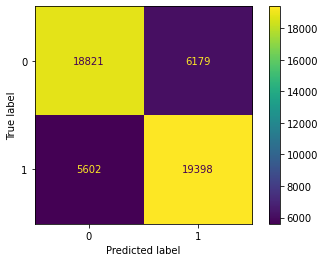

Conf Mat on Val Data:


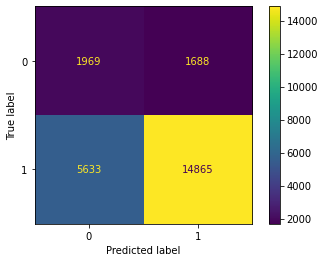

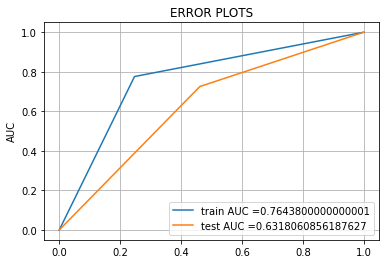

In [258]:
disp_comprehensive_res(rfr, X_cv, y_cv)

### XGBoost

In [259]:
# %%time

# clf = XGBClassifier()
# parameters = {
#             'max_depth':[3, 5, 7, 9],
#             'min_child_weight':[1, 3, 5],
#             'gamma':[0.0, 0.1, 0.2, 0.3, 0.4],
#             'subsample':[0.6, 0.7, 0.8, 0.9],
#             'colsample_bytree':[0.6, 0.7, 0.8, 0.9],
#             'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
#               }

# clf = GridSearchCV(clf, parameters, cv=5, scoring='roc_auc')
# clf.fit(X_train, y_train)

# scores(clf, X_train, y_train, X_cv, y_cv, False)

In [260]:
# clf.best_params_

In [261]:
# disp_comprehensive_res(clf, X_cv, y_cv)

In [262]:
# %%time

# tacc_l = []
# vacc_l = []

# max_depths = [5, 7, 8, 9, 10, 12, 15]
# for i in max_depths:
  
#   clf = XGBClassifier(max_depth = i)
#   clf.fit(X_train, y_train)

#   tacc, vacc = scores(clf, X_train, y_train, X_cv, y_cv, True)
#   tacc_l.append(tacc)
#   vacc_l.append(vacc)

# plt.plot(max_depths, tacc_l, label='Train')
# plt.plot(max_depths, vacc_l, label='Validation')

# plt.legend()
# plt.show()

In [263]:
# %%time

# tacc_l = []
# vacc_l = []

# min_child_weight = [1, 3, 5]

# for i in min_child_weight:
  
#   clf = XGBClassifier(max_depth = 8, min_child_weight = i)
#   clf.fit(X_train, y_train)

#   tacc, vacc = scores(clf, X_train, y_train, X_cv, y_cv, True)
#   tacc_l.append(tacc)
#   vacc_l.append(vacc)

# plt.plot(min_child_weight, tacc_l, label='Train')
# plt.plot(min_child_weight, vacc_l, label='Validation')

# plt.legend()
# plt.show()

In [264]:
# %%time

# tacc_l = []
# vacc_l = []

# gamma = [0.0, 0.1, 0.2, 0.3, 0.4]

# for i in gamma:
  
#   clf = XGBClassifier(max_depth = 8, min_child_weight = 3, gamma = i)
#   clf.fit(X_train, y_train)

#   tacc, vacc = scores(clf, X_train, y_train, X_cv, y_cv, True)
#   tacc_l.append(tacc)
#   vacc_l.append(vacc)

# plt.plot(gamma, tacc_l, label='Train')
# plt.plot(gamma, vacc_l, label='Validation')

# plt.legend()
# plt.show()

In [265]:
clf = XGBClassifier(max_depth = 8, min_child_weight = 3, gamma = 0.3)
clf.fit(X_train, y_train)

scores(clf, X_train, y_train, X_cv, y_cv, False)

# Train Accuracy:  0.88072
# Val Accuracy:  0.7322707513972262

Train Accuracy:  0.87744
Val Accuracy:  0.7301179879942041


Train Accuracy:  0.87744
Val Accuracy:  0.7301179879942041


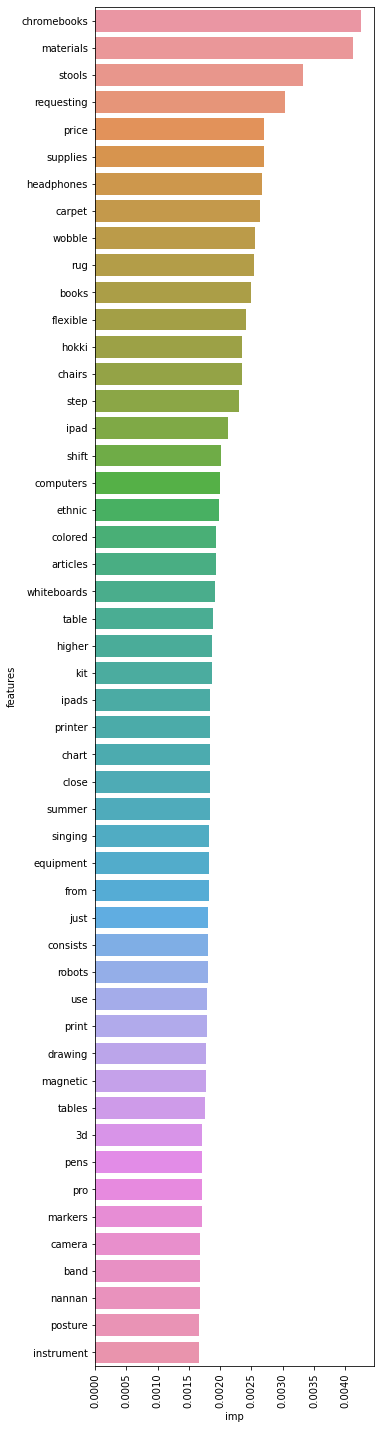

Conf Mat on Train Data:


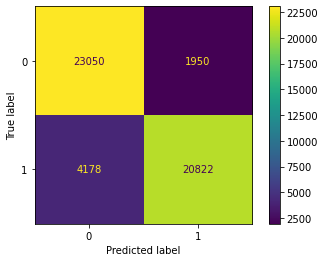

Conf Mat on Val Data:


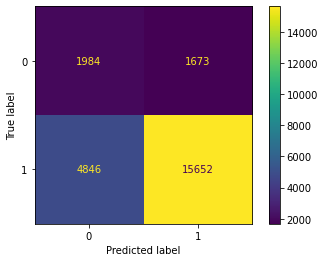

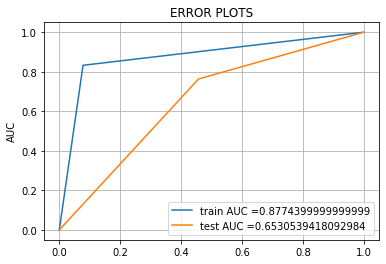

In [266]:
disp_comprehensive_res(clf, X_cv, y_cv)

In [267]:
# clf = XGBClassifier(max_depth = 8, min_child_weight = 3, gamma = 0.3)
# clf.fit(X_train[:,indexes], y_train)
# scores(clf, X_train[:,indexes], y_train, X_cv[:,indexes], y_cv, False)

In [269]:
# y_train_pred =   clf.predict(X_train[:,indexes])
# y_test_pred = clf.predict(X_cv[:,indexes])

# train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
# test_fpr, test_tpr, te_thresholds = roc_curve(y_cv, y_test_pred)

# plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
# plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
# plt.legend()
# plt.ylabel("AUC")
# plt.title("ERROR PLOTS")
# plt.grid()
# plt.show()

### Final Performances On Val Data

In [270]:
x = PrettyTable()
x.field_names = ["Model", "Hyperparameter", "Accuracy", "AUC"]
x.add_row(["DecisionTree", "criterion= 'gini', max_depth = 25, min_samples_leaf = 5", "0.64", "0.58"])
x.add_row(["Random Forest", "max_depth = 9, n_estimators=100", "0.69", "0.63"])
x.add_row(["XGBClassifier", "max_depth = 8, min_child_weight = 3, gamma = 0.3", "0.73", "0.65"])
print(x)

+---------------+---------------------------------------------------------+----------+------+
|     Model     |                      Hyperparameter                     | Accuracy | AUC  |
+---------------+---------------------------------------------------------+----------+------+
|  DecisionTree | criterion= 'gini', max_depth = 25, min_samples_leaf = 5 |   0.64   | 0.58 |
| Random Forest |             max_depth = 9, n_estimators=100             |   0.69   | 0.63 |
| XGBClassifier |     max_depth = 8, min_child_weight = 3, gamma = 0.3    |   0.73   | 0.65 |
+---------------+---------------------------------------------------------+----------+------+


### Final Performance On Test Data

Train Accuracy:  0.85562
Val Accuracy:  0.6280650171973816


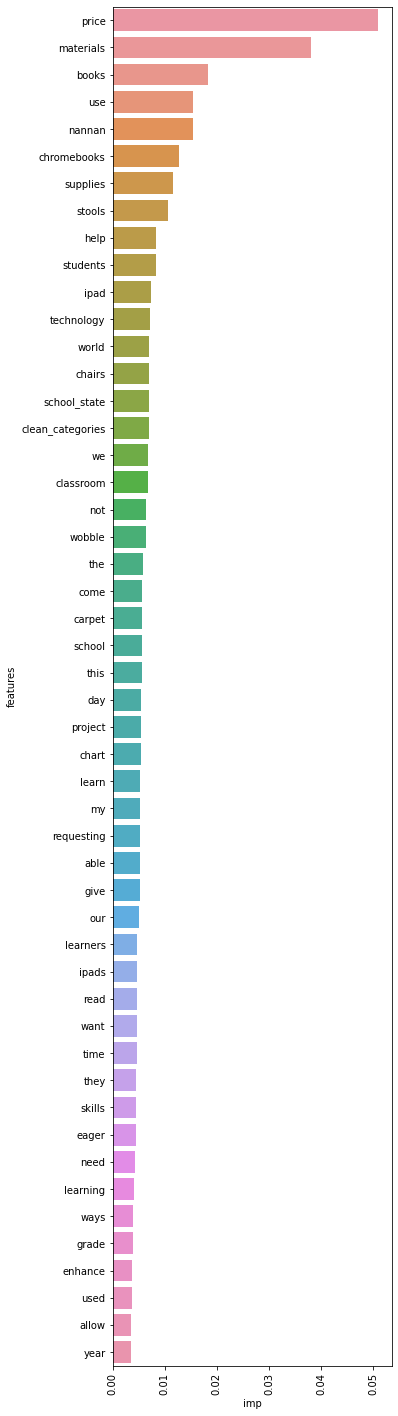

Conf Mat on Train Data:


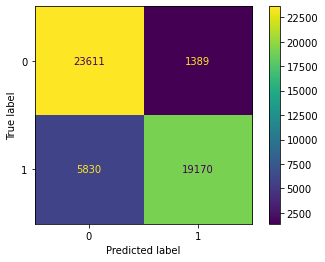

Conf Mat on Val Data:


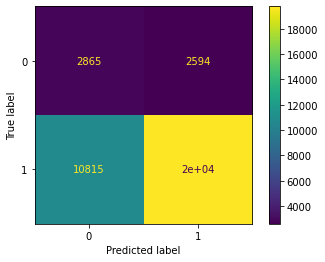

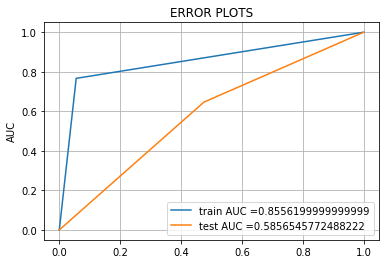

In [271]:
clf = DecisionTreeClassifier(criterion= 'gini', max_depth = 25, min_samples_leaf = 5)
clf.fit(X_train, y_train)
disp_comprehensive_res(clf, X_test, y_test)

Train Accuracy:  0.75806
Val Accuracy:  0.6860645733939864


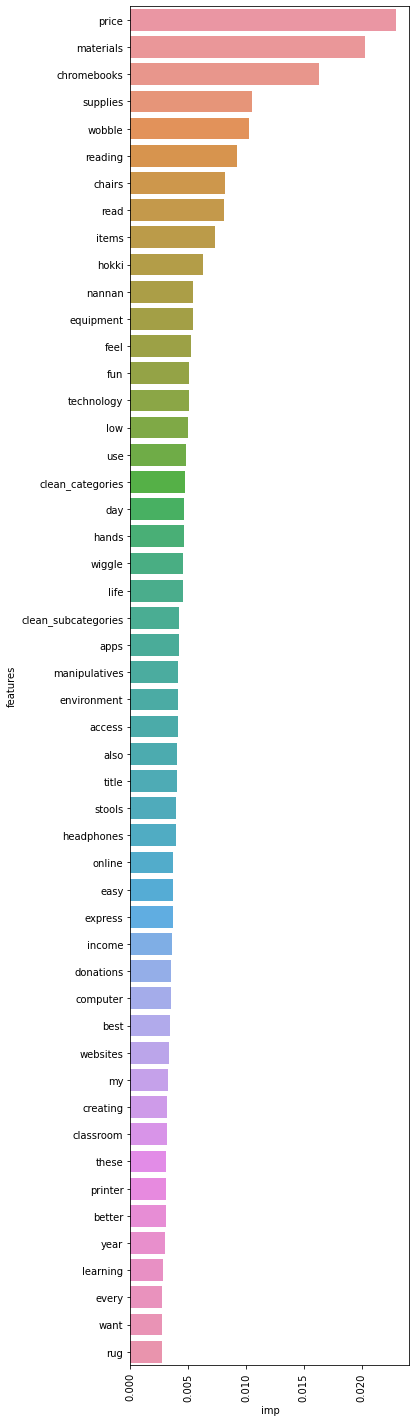

Conf Mat on Train Data:


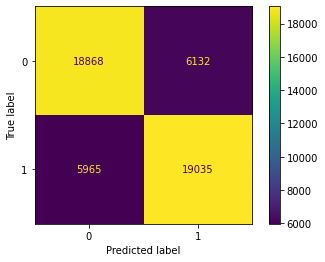

Conf Mat on Val Data:


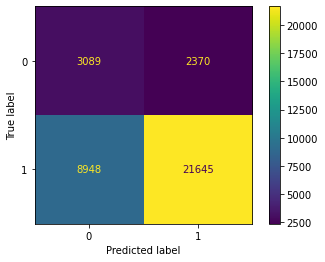

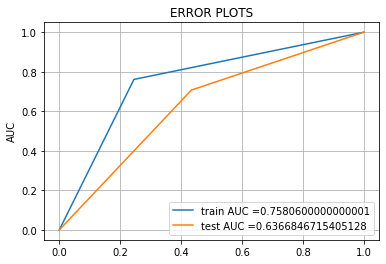

In [272]:
clf = RandomForestClassifier(max_depth = 9, n_estimators=100)
clf.fit(X_train, y_train)
disp_comprehensive_res(clf, X_test, y_test)

Train Accuracy:  0.87744
Val Accuracy:  0.7347719960057695


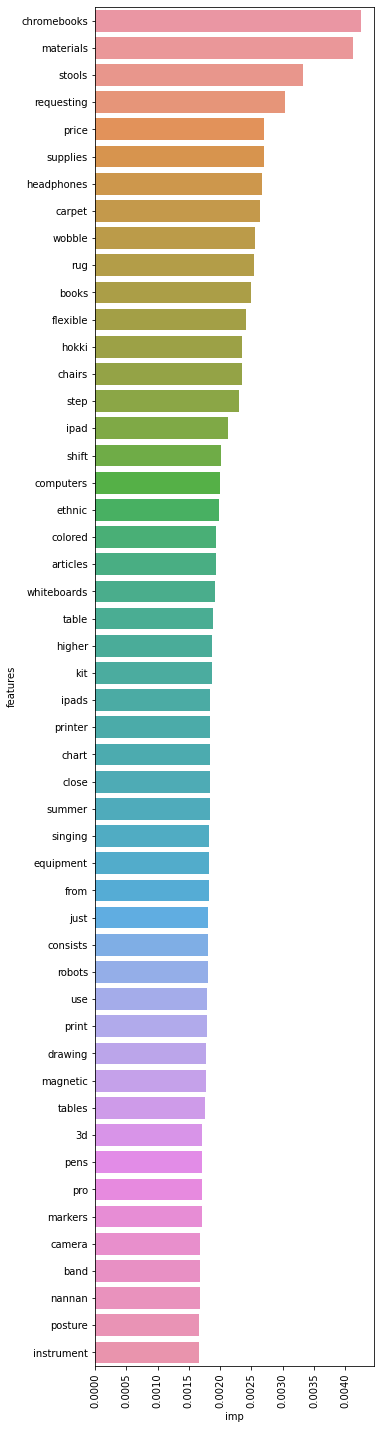

Conf Mat on Train Data:


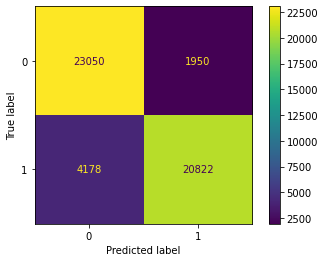

Conf Mat on Val Data:


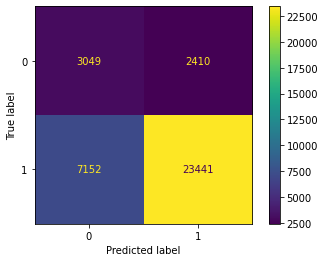

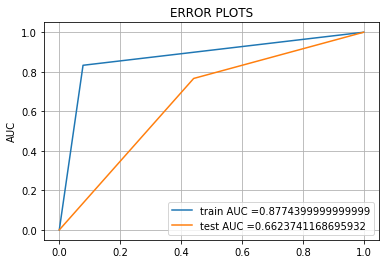

In [273]:
clf = XGBClassifier(max_depth = 8, min_child_weight = 3, gamma = 0.3)
clf.fit(X_train, y_train)
disp_comprehensive_res(clf, X_test, y_test)

In [275]:
x = PrettyTable()
x.field_names = ["Model", "Hyperparameter", "Accuracy", "AUC"]
x.add_row(["DecisionTree", "criterion= 'gini', max_depth = 25, min_samples_leaf = 5", "0.62", "0.58"])
x.add_row(["Random Forest", "max_depth = 9, n_estimators=100", "0.68", "0.63"])
x.add_row(["XGBClassifier", "max_depth = 8, min_child_weight = 3, gamma = 0.3", "0.73", "0.66"])
print(x)

+---------------+---------------------------------------------------------+----------+------+
|     Model     |                      Hyperparameter                     | Accuracy | AUC  |
+---------------+---------------------------------------------------------+----------+------+
|  DecisionTree | criterion= 'gini', max_depth = 25, min_samples_leaf = 5 |   0.62   | 0.58 |
| Random Forest |             max_depth = 9, n_estimators=100             |   0.68   | 0.63 |
| XGBClassifier |     max_depth = 8, min_child_weight = 3, gamma = 0.3    |   0.73   | 0.66 |
+---------------+---------------------------------------------------------+----------+------+


### Improvements Possible

1. The data used here is a small subset of the large data provided in the competition. If more time is invested, then surely more columns could be taken into consideration. That would definitely improve the performance.

2. We can also try W2V.

3. We can try deep learning models to improve the prediction quality.